In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt

INTERVAL = 10
INTERVAL_SQUARED = INTERVAL**2
NUM_BINS = INTERVAL**3+INTERVAL**2+INTERVAL+1


def convert_rgb_tensor_to_key(tensor_data):
    scaled_data = (tensor_data*INTERVAL).to(torch.long)
    bucket = scaled_data[:,0]*INTERVAL_SQUARED+scaled_data[:,1]*INTERVAL+scaled_data[:,2]
    return bucket

class WeightedMSELoss(nn.MSELoss):
    
    def __init__(self, value_embedding_layer):
        super().__init__(reduction="none")
        self.value_embedding_layer = value_embedding_layer

        
    def forward(self, input, target):
        mse_loss = super().forward(input, target)
        bucket = convert_rgb_tensor_to_key(target)
        value_embeddings = self.value_embedding_layer(bucket).squeeze()
        mse_loss = torch.mean(mse_loss, dim=1)
        weighted_mse_loss = (mse_loss * value_embeddings).mean()
        return weighted_mse_loss


In [2]:
!pip install ptlflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.2 requires cubinlinker, which is not installed.
cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
aiobotocore 2.13.2 requires botocore<1.34.132,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
albumentations 1.4.14 requires pydantic>=2.7.0, but you have pydantic 1.10.18 which is incompatible.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-clo

In [3]:
!git clone https://github.com/zhangmozhe/Deep-Exemplar-based-Video-Colorization.git
    
%cd /kaggle/working/Deep-Exemplar-based-Video-Colorization/

!pip install prefetch_generator
!pip install pypng

!wget https://github.com/zhangmozhe/Deep-Exemplar-based-Video-Colorization/releases/download/v1.0/colorization_checkpoint.zip
!unzip colorization_checkpoint.zip

Cloning into 'Deep-Exemplar-based-Video-Colorization'...
remote: Enumerating objects: 2375, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 2375 (delta 22), reused 11 (delta 10), pack-reused 2347 (from 1)
Receiving objects: 100% (2375/2375), 470.01 MiB | 28.64 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Updating files: 100% (1209/1209), done.
/kaggle/working/Deep-Exemplar-based-Video-Colorization
  Preparing metadata (setup.py) ... done
  Created wheel for prefetch_generator: filename=prefetch_generator-1.0.3-py3-none-any.whl size=4757 sha256=9cf0d78b635f78f8274501d339394ee69cf723d94567ea8d9c5d1eee1d93ba16
  Stored in directory: /root/.cache/pip/wheels/65/65/44/ed059bc23eeda93cfb19b58113423882cd9febae7ebf3f9ddf
Successfully built prefetch_generator
--2024-09-01 13:16:39--  https://github.com/zhangmozhe/Deep-Exemplar-based-Video-Colorization/releases/download/v1.0/colorization_checkpoint.zip
Resolving github.com

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
#from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
# from torchsummary import summary
from kornia import color

from __future__ import print_function

import os
import time

import cv2
import numpy as np
import torch.backends.cudnn as cudnn
import torchvision.transforms as transform_lib

import lib.TestTransforms as transforms
from models.ColorVidNet import ColorVidNet
from models.FrameColor import frame_colorization
from models.NonlocalNet import VGG19_pytorch, WarpNet
from utils.util import (batch_lab2rgb_transpose_mc, folder2vid, mkdir_if_not,
                        save_frames, tensor_lab2rgb, uncenter_l)
from utils.util_distortion import CenterPad, Normalize, RGB2Lab, ToTensor

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["TORCH_USE_CUDA_DSA"] = "1"
#torch.cuda.set_device(0)

image_size = [216, 384]

transform = transforms.Compose([RGB2Lab(), ToTensor(), Normalize()])
transform_resize = transforms.Compose([CenterPad(image_size), transform_lib.CenterCrop(image_size), RGB2Lab(), ToTensor(), Normalize()])

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/kaggle/working/Deep-Exemplar-based-Video-Colorization/models/vgg19_gray.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_sa

In [5]:
class Places365Train(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = sorted(list(self.data_dir.rglob("*.jpg")))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white and lab color space.

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and lab color space image
        """
        with Image.open(self.data_paths[idx]) as img:
            rgb_img = transform_lib.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            #rgb_img = transform_resize(img)
            bw_img = transform_lib.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        lab_img = color.rgb_to_lab(rgb_img)  # (3, 256, 256) -> L, a, b
        lab_img[0] = lab_img[0] / 100  # L channel
        lab_img[1:] = lab_img[1:] / 128  # a, b channel

        return bw_img, rgb_img

    @staticmethod
    def lab_to_rgb(lab_img: torch.Tensor) -> torch.Tensor:
        return lab_img
        """Convert lab image to rgb image.

        Args:
            lab_img (torch.Tensor): Lab color space image

        Returns:
            torch.Tensor: RGB image
        """
        lab_img[0] = lab_img[0] * 100  # L channel
        lab_img[1:] = lab_img[1:] * 128  # a, b channel
        rgb_img = color.lab_to_rgb(lab_img)
        return rgb_img

In [6]:
frames_dataset = Places365Train(Path("/kaggle/input/davis-2017-trainval/DAVIS_resized"))

In [45]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class VideoFramesDataset(Dataset):
    def __init__(self, root_dir: str):
        self.root_dir = Path(root_dir)
        #self.root_dir_resized = Path(resized_dir)
        self.video_folders = sorted(list(self.root_dir.glob('*')))  # Each folder is a video
        #self.video_folders_resized = sorted(list(self.root_dir_resized.glob('*')))

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        video_folder = self.video_folders[idx]
        #video_folder_resized = self.video_folders_resized[idx]
        frame_paths = sorted(list(video_folder.glob('*.jpg')))  # Sort to ensure sequential order
        #frame_paths_resized = sorted(list(video_folder_resized.glob('*.jpg')))

        frames = []
        bw_frames = []
        bw_frames_deep = []
#         for frame_path, frame_path_resized in zip(frame_paths, frame_paths_resized):
        for frame_path in frame_paths:
#             with Image.open(frame_path) as img:
# #                 frame = transform_resize(img)
# #                 frames.append(frame)

#                 bw_frame_deep = transform_resize(img)
#                 bw_frame_deep[1:3, :, :] = 0
#                 bw_frames_deep.append(bw_frame_deep)
            
            with Image.open(frame_path) as img:
                bw_frame = transform_lib.ToTensor()(img.convert("L"))
                frame = transform_lib.ToTensor()(img.convert("RGB"))
                bw_frame = bw_frame.repeat(3, 1, 1)
                bw_frame[1:3, :, :] = 0
                frames.append(frame)
                bw_frames.append(bw_frame)
                bw_frame[0:1, ...] = (bw_frame[0:1, ...] * 100) - 50
                bw_frame = torch.nn.functional.interpolate(bw_frame.unsqueeze(0), size=(216, 384), mode="bilinear", align_corners=False)
                bw_frames_deep.append(bw_frame.squeeze(0))
                
                

        frames = torch.stack(frames)  # (N, C, H, W), where N is the number of frames
        bw_frames = torch.stack(bw_frames)
        bw_frames_deep = torch.stack(bw_frames_deep)
        return frames, bw_frames, bw_frames_deep


In [46]:
from torch.utils.data import DataLoader

# directory = "/kaggle/input/davis-2017-trainval-480p/DAVIS/JPEGImages/480p/"
# vid_directory = '/kaggle/input/davis-2017-test-dev-480p/DAVIS/JPEGImages/480p/'
directory = '/kaggle/input/davis-2017-trainval/DAVIS_resized'
vid_directory = '/kaggle/input/davis-2017-test-dev/DAVIS_resized'

# Initialize the dataset
dataset = VideoFramesDataset(root_dir=directory)
vid_dataset = VideoFramesDataset(root_dir=vid_directory)

In [36]:
len(dataset), len(vid_dataset)

(90, 30)

In [47]:
import torch
from torch.utils.data import random_split

train_ratio = 0.8
test_ratio = 0.2  
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_set, val_set = random_split(dataset, [train_size, test_size])

len(train_set), len(val_set)

(72, 18)

In [12]:
occurrence = torch.zeros(NUM_BINS)
for data in tqdm(frames_dataset):
    rgb_image = data[1]
    key = convert_rgb_tensor_to_key(rgb_image).view(-1)
    bin_counts = torch.bincount(key, minlength = NUM_BINS)
    occurrence += bin_counts

100%|██████████| 6208/6208 [01:20<00:00, 76.89it/s]


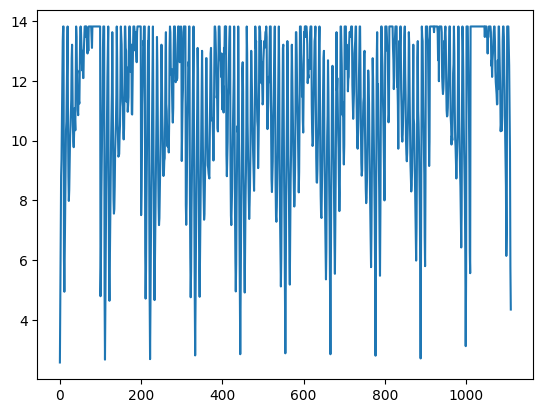

In [13]:
import matplotlib.pyplot as plt

probabilities = (occurrence/torch.sum(occurrence)).view(-1)
probabilities = -torch.log(probabilities+1e-6).view(-1,1)
plt.plot(probabilities.view(-1))

In [14]:
value_embedding = nn.Embedding(num_embeddings=NUM_BINS, embedding_dim=1) 
value_embedding.weight.data = probabilities
value_embedding = value_embedding.to("cuda")

In [15]:
class Block(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.Tanh()  # todo: change to ReLU
        self.upsample = torch.nn.Upsample(scale_factor=upsample)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(self.relu(self.bn(self.conv(x))))

In [16]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.FEATURE_EXTRACTOR_LAYERS = 9
        self.feature_extractor = efficientnet_b7(
            weights=EfficientNet_B7_Weights.IMAGENET1K_V1
        ).features
        # *****************
        #self.feature_extractor[0][0] = nn.Conv2d(6, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # *****************
        self.feature_extractor.requires_grad_(False)

        self.colorization_layers = torch.nn.Sequential(
            Block(2560, 640),
            Block(640, 384),
            Block(384, 224, upsample=2),
            Block(224, 160),
            Block(160, 80, upsample=2),
            Block(80, 48, upsample=2),
            Block(48, 32, upsample=2),
            Block(32, 64, upsample=2),
            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.Sigmoid(),
        )
        self.quantized = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        #x = torch.nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        
        feature32 = self.feature_extractor[0:2](
            x
        )  # 3x256x256 -> 64x128x128 -> 32x128x128
        feature48 = self.feature_extractor[2](feature32)  # 32x128x128 -> 48x64x64
        feature80 = self.feature_extractor[3](feature48)  # 48x64x64 -> 80x32x32
        feature224 = self.feature_extractor[4:6](
            feature80
        )  # 80x32x32 -> 160x16x16 -> 224x16x16
        feature640 = self.feature_extractor[6:8](
            feature224
        )  # 224x16x16 -> 384x8x8 -> 640x8x8
        feature2560 = self.feature_extractor[8](feature640)  # 640x8x8 -> 2560x8x8
        
        if not self.quantized:
            out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
            out += feature640
            out = self.colorization_layers[1:3](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
            out += feature224
            out = self.colorization_layers[3:5](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
            out += feature80
            out = self.colorization_layers[5](out)  # 80x64x64 -> 48x128x128
            out += feature48
            out = self.colorization_layers[6](out)  # 48x128x128 -> 32x256x256
            out += feature32
            out = self.colorization_layers[7:10](
                out
            )  # 32x256x256 -> 64x256x256 -> 2x256x256
        else:
            out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
            out += feature640
            out = self.colorization_layers[1](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
            out += feature224
            out = self.colorization_layers[2](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
            out += feature80
            out = self.colorization_layers[3](out)  # 80x64x64 -> 48x128x128
            out += feature48
            out = self.colorization_layers[4](out)  # 48x128x128 -> 32x256x256
            out += feature32
            out = self.colorization_layers[5](out)  # 32x256x256 -> 64x256x256 -> 2x256x256
        
        #out = torch.nn.functional.interpolate(out, size=(216, 384), mode='bilinear', align_corners=False)
        
        return out

    def convert_output_to_rgb(
        self, x: torch.Tensor, output: torch.Tensor
    ) -> torch.Tensor:

        return output
        lab_img = x.clone()
        lab_img[1:] = output
        return Places365Train.lab_to_rgb(lab_img)

In [17]:
def prep_output(output, input):
    input_l = input[:, 0:1, :, :]
    output_ab = output[:, 1:3, :, :]
    return torch.cat((input_l, output_ab), dim=1)

In [18]:
class deepExemplarModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nonlocal_net = WarpNet(1)
        self.colornet = ColorVidNet(7)
        self.vggnet = VGG19_pytorch()
        self.vggnet.load_state_dict(torch.load("data/vgg19_conv.pth"))
        for param in self.vggnet.parameters():
            param.requires_grad = False

        nonlocal_test_path = os.path.join("checkpoints/", "video_moredata_l1/nonlocal_net_iter_76000.pth")
        color_test_path = os.path.join("checkpoints/", "video_moredata_l1/colornet_iter_76000.pth")
        print("succesfully load nonlocal model: ", nonlocal_test_path)
        print("succesfully load color model: ", color_test_path)
        self.nonlocal_net.load_state_dict(torch.load(nonlocal_test_path))
        self.colornet.load_state_dict(torch.load(color_test_path))

        self.nonlocal_net.eval()
        self.colornet.eval()
        self.vggnet.eval()
        self.nonlocal_net.cuda()
        self.colornet.cuda()
        self.vggnet.cuda()

    def forward(self, current_frame, ref_frame, prev_frame_predict):
        ref_frame = torch.nn.functional.interpolate(ref_frame, size=(216, 384), mode='bilinear', align_corners=False)
#         ref_frame = frames_dataset.lab_to_rgb(ref_frame.squeeze(0)).permute(1, 2, 0).detach().cpu()
#         IB_lab = transform(ref_frame).unsqueeze(0)
#         IB_lab = IB_lab.cuda()
        ref_frame[:, 0:1, ...] = (ref_frame[:, 0:1, ...] * 100) - 50
        ref_frame[:, 1:3, ...] = (ref_frame[:, 1:3, ...] * 255) - 128
        ref_frame = ref_frame.cuda()
#         print("nix")
        
        with torch.no_grad():
            I_reference_lab = ref_frame
            I_reference_l = I_reference_lab[:, 0:1, :, :]
            I_reference_ab = I_reference_lab[:, 1:3, :, :]
            I_reference_rgb = tensor_lab2rgb(torch.cat((uncenter_l(I_reference_l), I_reference_ab), dim=1))
            features_B = self.vggnet(I_reference_rgb, ["r12", "r22", "r32", "r42", "r52"], preprocess=True)
        
        IA_l = current_frame[:, 0:1, :, :]
        
        with torch.no_grad():
            I_current_lab = current_frame
#             print("here")
            I_current_ab_predict, I_current_nonlocal_lab_predict, features_current_gray = frame_colorization(
                I_current_lab,
                I_reference_lab,
                prev_frame_predict,
                features_B,
                self.vggnet,
                self.nonlocal_net,
                self.colornet,
                feature_noise=0,
                temperature=1e-10,
            )
            I_lab_predict = torch.cat((IA_l, I_current_ab_predict), dim=1)
            
        return I_lab_predict, I_current_ab_predict

In [ ]:
import torch.nn.functional as F
import cv2
import ptlflow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_optical_flow(flownet2, frame1, frame2):
    # Ensure frames are in float format (if not already)
    frame1 = frame1.float()  # Shape: (B, 3, H, W)
    frame2 = frame2.float()  # Shape: (B, 3, H, W)
        
    # Stack frames along a new dimension to match the required 5D tensor shape
    # Resulting shape should be (B, 2, 3, H, W)
    input_pair = torch.stack([frame1, frame2], dim=1)

    # Create the input dictionary for FlowNet2
    inputs = {'images': input_pair}

    # Compute the flow using FlowNet2
    with torch.no_grad():  # Disable gradient calculation for inference
        flow = flownet2(inputs)['flows']
    #print("flow calculated\n", flow)
    return flow

def warp_frame(frame, flow):
    # Warp the frame according to the optical flow
    #frame = frame[0:1]
    B, C, H, W = frame.size()
    flow = flow.squeeze(1)
    flow = flow.permute(0, 2, 3, 1).contiguous()
    grid = create_grid(H, W).to(flow.device)
    warped_grid = grid + flow
    warped_grid = 2.0 * warped_grid / torch.tensor([W - 1, H - 1], device=flow.device).view(1, 1, 1, 2) - 1.0    # (B, H, W, 2)
    warped_frame = F.grid_sample(frame, warped_grid, align_corners=True)
    return warped_frame     # (1, 2, H, W)

def create_grid(H, W):
    # Create a grid for warping
    x = torch.arange(0, W).view(1, -1).repeat(H, 1)
    y = torch.arange(0, H).view(-1, 1).repeat(1, W)
    grid = torch.stack((x, y), dim=2).float()
    grid = grid.unsqueeze(0).repeat(1, 1, 1, 1)
    return grid

def warp_inputs_1_to_2(input1, input2):
    flownet2 = ptlflow.get_model('flownet2', pretrained_ckpt='things').to(device)
    flownet2.eval()
    flow_forward = compute_optical_flow(flownet2, input1, input2)
    warped_output = warp_frame(input1, flow_forward)
    
    return warped_output

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([3, 256, 256])


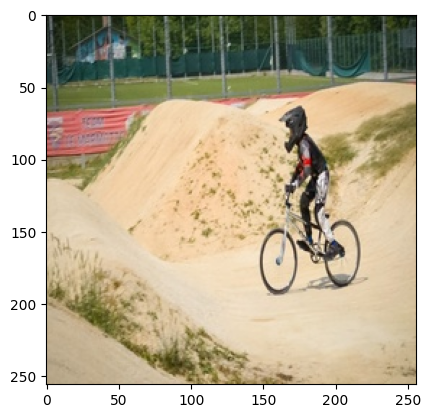

In [21]:
input1 = frames_dataset[205][1].to(device)
print(input1.shape)
plt.imshow(frames_dataset.lab_to_rgb(input1).permute(1, 2, 0).cpu())

torch.Size([3, 256, 256])


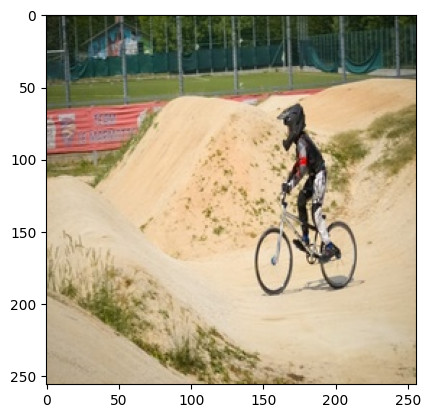

In [22]:
input2 = frames_dataset[206][1].to(device)
print(input2.shape)
plt.imshow(frames_dataset.lab_to_rgb(input2).permute(1, 2, 0).cpu())

Downloading: "https://github.com/hmorimitsu/ptlflow/releases/download/weights1/flownet2-things-d63b53a7.ckpt" to /root/.cache/torch/hub/ptlflow/checkpoints/flownet2-things-d63b53a7.ckpt
100%|██████████| 620M/620M [00:20<00:00, 31.2MB/s] 


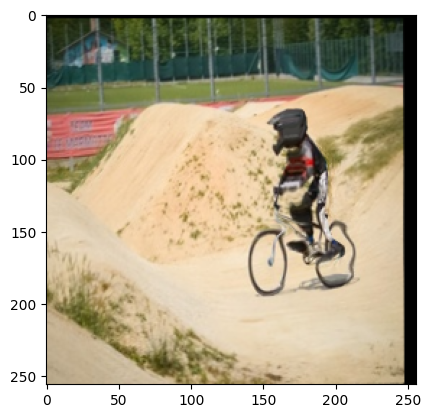

In [23]:
warped = warp_inputs_1_to_2(input1.unsqueeze(0), input2.unsqueeze(0))
#print(warped.shape)
plt.imshow(frames_dataset.lab_to_rgb(warped.squeeze(0)).permute(1, 2, 0).cpu())

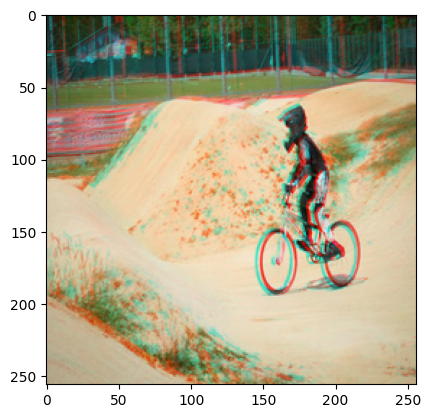

In [24]:
t = prep_output(input1.unsqueeze(0), input2.unsqueeze(0))
plt.imshow(frames_dataset.lab_to_rgb(t.squeeze(0)).permute(1, 2, 0).cpu())

In [20]:
#train model

from torch.optim import AdamW
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNetWithEfficientNetFeatureExtractor().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3)
mseloss = MSELoss()
weighted_mseloss = WeightedMSELoss(value_embedding)
deep_exemplar_model = deepExemplarModel().to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:06<00:00, 38.8MB/s] 


replace all deconv with [nearest + conv]
replace all batchnorm with instancenorm


/tmp/ipykernel_36/909032756.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vggnet.load_state_dict(torch.load("data/vgg19_conv.pth"))
/tmp/ipykernel_36/909032756.py

succesfully load nonlocal model:  checkpoints/video_moredata_l1/nonlocal_net_iter_76000.pth
succesfully load color model:  checkpoints/video_moredata_l1/colornet_iter_76000.pth


In [21]:
import torchvision
import torchvision.models as models

# Load the pre-trained VGG11 model
vgg11 = models.vgg11(pretrained=True)

vgg11.features[-1]=torch.nn.Identity()
vgg11 = vgg11.features

for param in vgg11.parameters():
    param.requires_grad = False
    
vgg11 = vgg11.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 208MB/s]  


In [22]:
import torch.nn.functional as F
import cv2
import ptlflow

OCCLUSION_MASK_INCONSISTENCY_THRESHOLD = 0.75

class TemporalConsistencyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the FlowNet2 model
        self.flownet2 = ptlflow.get_model('flownet2', pretrained_ckpt='things').to(device)  # Assuming you're using a GPU
        self.flownet2.eval()

    def forward(self, prev_output, current_output, prev_frame, current_frame):
        # Compute optical flow between the previous and current frames using FlowNet2
        flow_forward = self.compute_optical_flow(prev_frame, current_frame)
        
        # Compute backward flow (from current frame to previous frame)
        flow_backward = self.compute_optical_flow(current_frame, prev_frame)
        
        # Warp the previous frame's output to the current frame
        warped_prev_output = self.warp_frame(prev_output, flow_forward)
        
        # Calculate the binary mask to exclude occluded regions using bidirectional consistency check
        mask = self.compute_mask(flow_forward, flow_backward)
        
        # Calculate the temporal consistency loss
        temporal_loss = mask * (warped_prev_output - current_output).pow(2)
        
        return temporal_loss.mean()

    def compute_optical_flow(self, frame1, frame2):
        # Ensure frames are in float format (if not already)
        frame1 = frame1.float()  # Shape: (B, 3, H, W)
        frame2 = frame2.float()  # Shape: (B, 3, H, W)
        
        # Stack frames along a new dimension to match the required 5D tensor shape
        # Resulting shape should be (B, 2, 3, H, W)
        input_pair = torch.stack([frame1, frame2], dim=1)

        # Create the input dictionary for FlowNet2
        inputs = {'images': input_pair}

        # Compute the flow using FlowNet2
        with torch.no_grad():  # Disable gradient calculation for inference
            flow = self.flownet2(inputs)['flows']

        return flow

    def warp_frame(self, frame, flow):
        # Warp the frame according to the optical flow
        #frame = frame[0:1]
        B, C, H, W = frame.size()
        flow = flow.squeeze(1)
        flow = flow.permute(0, 2, 3, 1).contiguous()
        grid = self.create_grid(H, W).to(flow.device)
        warped_grid = grid + flow
        warped_grid = 2.0 * warped_grid / torch.tensor([W - 1, H - 1], device=flow.device).view(1, 1, 1, 2) - 1.0    # (B, H, W, 2)
        warped_frame = F.grid_sample(frame, warped_grid, align_corners=True)
        return warped_frame     # (1, 2, H, W)

    def create_grid(self, H, W):
        # Create a grid for warping
        x = torch.arange(0, W).view(1, -1).repeat(H, 1)
        y = torch.arange(0, H).view(-1, 1).repeat(1, W)
        grid = torch.stack((x, y), dim=2).float()
        grid = grid.unsqueeze(0).repeat(1, 1, 1, 1)
        return grid

    def compute_mask(self, flow_forward, flow_backward):
        # Compute a binary mask using the bidirectional flow consistency check
        flow_forward = flow_forward.squeeze(1)
        flow_backward = flow_backward.squeeze(1)
        B, C, H, W = flow_forward.size()
        
        # Create a grid and warp it with the forward flow to predict the current frame
        grid = self.create_grid(H, W).to(flow_forward.device)
        warped_grid = grid + flow_forward.permute(0, 2, 3, 1).contiguous()  # (1, H, W, 2)
        
        # Warp the backward flow to align with the forward flow
        backward_flow_warped = F.grid_sample(flow_backward, warped_grid.contiguous(), align_corners=True)  # (1, H, W, 2)
        
        # Compute the difference between the original forward flow and the warped backward flow
        flow_diff = torch.abs(flow_forward + backward_flow_warped)
        
        # Set a threshold for consistency
        threshold = OCCLUSION_MASK_INCONSISTENCY_THRESHOLD  # You can adjust this value
        mask = (flow_diff.sum(dim=1, keepdim=True) < threshold).float()
        
        return mask

[!!alt_cuda_corr is not compiled!!]


In [23]:
# Initialize the temporal consistency loss
temporal_loss_fn = TemporalConsistencyLoss()

Downloading: "https://github.com/hmorimitsu/ptlflow/releases/download/weights1/flownet2-things-d63b53a7.ckpt" to /root/.cache/torch/hub/ptlflow/checkpoints/flownet2-things-d63b53a7.ckpt
100%|██████████| 620M/620M [00:14<00:00, 43.7MB/s] 


In [48]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)   # Batch size 1 means 1 video folder at a time
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
vid_loader = DataLoader(vid_dataset, batch_size=1, shuffle=False)

In [25]:
def format_frame(frame):
    #frame = frame.detach()
#     with torch.no_grad():
#         frame = torch.nn.functional.interpolate(frame, size=(216, 384), mode='bilinear', align_corners=False)
#         frame = frames_dataset.lab_to_rgb(frame.squeeze(0))
#         frame = frame.permute(1, 2, 0).detach().cpu()
#         frame = transform(frame).unsqueeze(0)
#         frame = frame.cuda()
    frame = torch.nn.functional.interpolate(frame, size=(216, 384), mode='bilinear', align_corners=False)
    frame[:, 0:1, ...] = (frame[:, 0:1, ...] * 100) - 50
    frame[:, 1:3, ...] = (frame[:, 1:3, ...] * 255) - 128
    return frame

In [50]:
PERCEPTUAL_LOSS_WEIGHT = 0.5
TEMPORAL_LOSS_WEIGHT = 0.3
def train(model, train_loader, val_loader, loss1, loss2, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for video_frames, bw_frames, bw_frames_deep in tqdm(train_loader):            # 5D tensor
            optimizer.zero_grad()
            
            video_frames = video_frames.squeeze(0).to(device)
            bw_frames = bw_frames.squeeze(0).to(device)
            bw_frames_deep = bw_frames_deep.squeeze(0).to(device)
            prev_output = None
            prev_x = None
            
            for i in range(len(video_frames)):
                y = video_frames[i]
                #prev_frame = prev_output if prev_output is not None else bw_frames[0]       # 4D tensor
                #prev_frame = bw_frames[i-1] if i>0 else bw_frames[0]
                #prev_frame = prep_input(prev_output, bw_frames[i]) if i > 0 else bw_frames[0]
                x = bw_frames[i]
                x_deep = bw_frames_deep[i]
                
                x, y, x_deep = x.unsqueeze(0).to(device), y.unsqueeze(0).to(device), x_deep.unsqueeze(0).to(device)
                # Forward pass through the model (train)
                ref_frame = model(x)  # Input shape: (1, 6, H, W)
                #ref_frame = prep_output(ref_frame, x)
                #print(ref_frame.shape)
                #print(ref_frame)
                
                if prev_output is None:
                    #prev_output = format_frame(ref_frame)
                    #prev_output = ref_frame
                    ref_frame = torch.nn.functional.interpolate(ref_frame, size=(216, 384), mode='bilinear', align_corners=False)
                    ref_frame[:, 0:1, ...] = (ref_frame[:, 0:1, ...] * 100) - 50
                    ref_frame[:, 1:3, ...] = (ref_frame[:, 1:3, ...] * 255) - 128
                    prev_output = ref_frame.detach()
                
#                 print(x_deep.shape, ref_frame.shape, prev_output.shape)
#                 print(prev_output)
                output_lab, output_ab = deep_exemplar_model(x_deep, ref_frame, prev_output)
                output_lab = output_lab.detach()
                output_ab = output_ab.detach()
#                 print(output_lab.shape, y.shape)
#                 print(output_lab)
                output_for_loss = output_lab
                output_for_loss[:, 0:1, ...] = (output_for_loss[:, 0:1, ...] + 50) / 100
                output_for_loss[:, 1:3, ...] = (output_for_loss[:, 1:3, ...] + 128) / 255
                output_for_loss = torch.nn.functional.interpolate(output_for_loss, size=(256, 256), mode='bilinear', align_corners=False)
#                 print(output_for_loss)
#                 print(y)
                loss = loss1(output_for_loss, y) + PERCEPTUAL_LOSS_WEIGHT*loss2(vgg11(output_for_loss),vgg11(y))
            
                # Add Temporal Consistency Loss if available
                if prev_x is not None:
                    temporal_loss = temporal_loss_fn(prev_output, output_lab, prev_x, x_deep)
                    loss += TEMPORAL_LOSS_WEIGHT * temporal_loss
        
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
                # Store the current output and input for the next iteration
                prev_output = output_lab
                #prev_output = output.detach() if i == 0 else prev_output
                prev_x = x_deep.detach()
            
        #train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        
        prev_output = None
        prev_x = None
        
        if val_loader is None:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")
            continue
            
        with torch.no_grad():
            for video_frames, bw_frames, bw_frames_deep in tqdm(val_loader):            # 5D tensor
                
                video_frames = video_frames.squeeze(0).to(device)
                bw_frames = bw_frames.squeeze(0).to(device)
                bw_frames_deep = bw_frames_deep.squeeze(0).to(device)
                prev_output = None
                prev_x = None

                for i in range(len(video_frames)):
                    y = video_frames[i]
                    #prev_frame = prev_output if prev_output is not None else bw_frames[0]       # 4D tensor
                    #prev_frame = bw_frames[i-1] if i>0 else bw_frames[0]
                    #prev_frame = prep_input(prev_output, bw_frames[i]) if i > 0 else bw_frames[0]
                    x = bw_frames[i]
                    x_deep = bw_frames_deep[i]

                    x, y, x_deep = x.unsqueeze(0).to(device), y.unsqueeze(0).to(device), x_deep.unsqueeze(0).to(device)

                    # Forward pass through the model
                    ref_frame = model(x)  # Input shape: (1, 6, H, W)
                    #ref_frame = prep_output(ref_frame, x)
                    
                    if prev_output is None:
                        prev_output = format_frame(ref_frame)

                    output_lab, output_ab = deep_exemplar_model(x_deep,ref_frame,prev_output)
                    output_for_loss = output_lab
                    output_for_loss[:, 0:1, ...] = (output_for_loss[:, 0:1, ...] + 50) / 100
                    output_for_loss[:, 1:3, ...] = (output_for_loss[:, 1:3, ...] + 128) / 255
                    output_for_loss = torch.nn.functional.interpolate(output_for_loss, size=(256, 256), mode='bilinear', align_corners=False)

                    loss = loss1(output_for_loss, y) + PERCEPTUAL_LOSS_WEIGHT*loss2(vgg11(output_for_loss),vgg11(y))
            
                    # Add Temporal Consistency Loss if available
                    if prev_x is not None:
                        temporal_loss = temporal_loss_fn(prev_output, output_lab, prev_x, x_deep)
                        loss += TEMPORAL_LOSS_WEIGHT * temporal_loss
                        
                    val_loss += loss.item()
                    prev_output = output_lab.detach()
                    #prev_output = output.detach() if i == 0 else prev_output
                    prev_x = x_deep.detach()
                
            #val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [54]:
 train(model, train_loader, val_loader, weighted_mseloss, mseloss, optimizer, device, epochs=1)
# train(model, vid_loader, None, weighted_mseloss, mseloss, optimizer, device, epochs=1)

100%|██████████| 18/18 [04:25<00:00, 14.73s/it]

Epoch 1/1, Train Loss: 1492.2793, Val Loss: 338.3308


In [ ]:
torch.save(model.state_dict(), "/kaggle/working/model.pth")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
frames_dataset = Places365Train(Path("/kaggle/input/davis-2017-test-dev/DAVIS_resized"))

torch.Size([3, 256, 256])


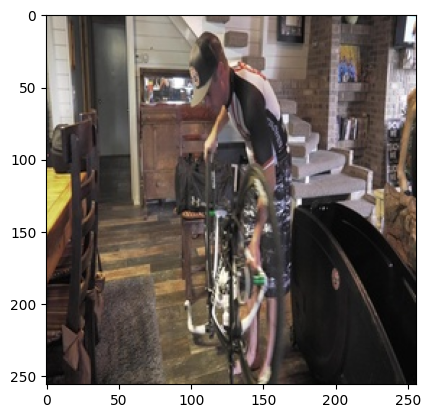

In [27]:
input = frames_dataset[99][1].to(device)
print(input.shape)
plt.imshow(frames_dataset.lab_to_rgb(input).permute(1, 2, 0).cpu())

torch.Size([3, 256, 256])


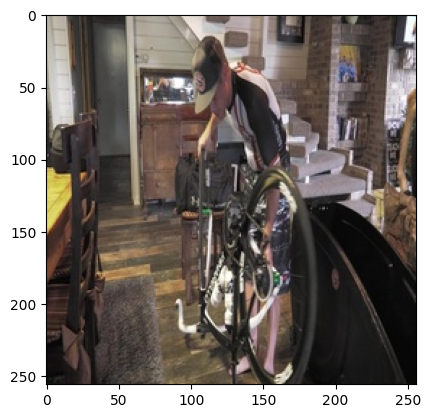

In [28]:
input = frames_dataset[100][1].to(device)
print(input.shape)
plt.imshow(frames_dataset.lab_to_rgb(input).permute(1, 2, 0).cpu())

torch.Size([1, 3, 216, 384])


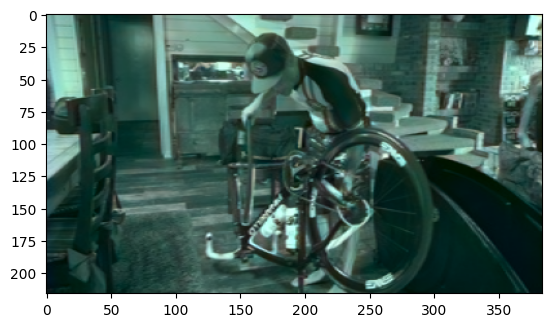

In [55]:
input_1 = frames_dataset[99][1].to(device).unsqueeze(0)
input_2 = frames_dataset[101][0].to(device).unsqueeze(0)
ref_frame = model(input_2)
ref_frame = prep_output(ref_frame, input_2)
x_deep = format_frame(input_2)
prev_output = format_frame(input_1)
output_lab, output_ab = deep_exemplar_model(x_deep,ref_frame,prev_output)

print(output_lab.shape)
output_rgb = batch_lab2rgb_transpose_mc(x_deep[:, 0:1, :, :], output_ab.detach(), nrow=1)
plt.imshow(output_rgb)

# output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
# print(output_img.shape)
# plt.imshow(output_img.permute(1, 2, 0))

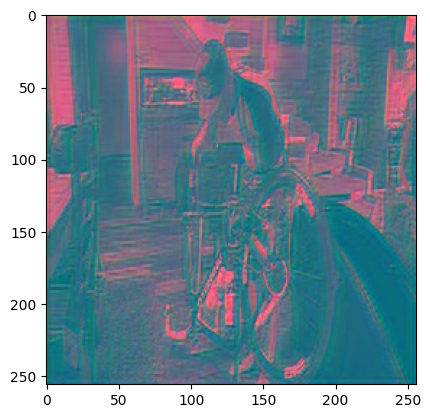

In [56]:
plt.imshow(frames_dataset.lab_to_rgb(ref_frame.squeeze(0).permute(1, 2, 0).detach().cpu()))

In [ ]:
video_frames, bw_frames, bw_frames_deep = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
bw_frames_deep = bw_frames_deep.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i].unsqueeze(0)
        #prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        #prev_frame = bw_frames[i-1] if i>0 else bw_frames[0]
        #prev_frame = prep_input(prev_output, bw_frames[i].unsqueeze(0)) if i > 0 else bw_frames[0]
        x = bw_frames[i].unsqueeze(0)
        x_deep = bw_frames_deep[i].unsqueeze(0)
        
        plt.subplot(4, 8, i * 2 + 1)
        #plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.imshow(batch_lab2rgb_transpose_mc(y[:, 0:1, :, :], y[:, 1:3, :, :]))
        plt.axis("off")

        # Concatenate prev_frame and x
#         input_tensor = torch.cat((prev_frame.squeeze(0), x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
#         input_tensor = input_tensor.to(device)
        ref_frame = model(x)
        ref_frame = prep_output(ref_frame, x)
        if prev_output is None:
            prev_output = format_frame(ref_frame)
        output, output_ab = deep_exemplar_model(x_deep,ref_frame,prev_output)

        # Forward pass through the model
#         output = model(input_tensor)
#         output = prep_output(output, x.unsqueeze(0))
#         output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        #plt.imshow(output_img.permute(1, 2, 0))
        plt.imshow(batch_lab2rgb_transpose_mc(x_deep[:, 0:1, :, :], output_ab))
        plt.axis("off")

        prev_output = output.detach()
        #prev_output = output.detach() if i == 0 else prev_output


In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = "output_videos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the model to evaluation mode
model.eval()

with torch.no_grad():  # Disable gradient calculation for testing
    for vid_idx in range(len(vid_dataset)):
        video_frames, bw_frames = vid_dataset[vid_idx]
        video_frames = video_frames.to(device)
        bw_frames = bw_frames.to(device)

        prev_output = None
        output_images = []

        for i in range(video_frames.size(0)):
            y = video_frames[i]
            #prev_frame = prev_output if prev_output is not None else bw_frames[0]  # 3D tensor
            prev_frame = bw_frames[i-1] if i>0 else bw_frames[0]
            x = bw_frames[i]

            # Concatenate prev_frame and x
            input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
            input_tensor = input_tensor.to(device)

            # Forward pass through the model
            output = model(input_tensor)
            output = prep_output(output, x.unsqueeze(0))
            output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
            output_img_np = output_img.permute(1, 2, 0).numpy()

            # Convert the image to a format suitable for OpenCV
            output_img_np = (output_img_np * 255).astype('uint8')
            output_images.append(output_img_np)

            prev_output = output.detach().squeeze(0)

        # Save the frames as a video file
        video_filename = os.path.join(output_dir, f"video_{vid_idx + 1}.mp4")
        height, width, _ = output_images[0].shape
        video_writer = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

        for img in output_images:
            video_writer.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV

        video_writer.release()
        print(f"Saved video {vid_idx + 1} to {video_filename}")


In [ ]:
import shutil

shutil.make_archive("/kaggle/working/output_videos", 'zip', "/kaggle/working/output_videos")

# Pruning

In [ ]:
def get_all_layers(model):
    layers = []

    def _get_layers_recursive(module):
        if not list(module.children()):
            layers.append(module)
        else:
            for child in module.children():
                _get_layers_recursive(child)
    _get_layers_recursive(model)
    return layers

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_next_conv_layer(layers, k):
    for i in range(k+1,len(layers)):
        if isinstance(layers[i], nn.Conv2d) and layers[k].weight.shape[1] == layers[i].weight.shape[0]:
            
            return i
    return -1

def get_prev_conv_layer(layers, k):
    for i in reverse(range(0,k)):
        if isinstance(layers[i], nn.Conv2d):
            return i
    return -1

def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    return int(round(channels*(1-prune_ratio)))

def find_index(layers, target):
    for i, layer in enumerate(layers):
        if layer == target:
            return i
def get_out_channel_importance(weight):
    out_channels = weight.shape[0]
    importances = []
    # compute the importance for each input channel
    for o_c in range(weight.shape[0]):
        channel_weight = weight.detach()[o_c]
        importance = torch.linalg.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)
def get_keep_indices(conv_layer, p_ratio):
    n_keep = get_num_channels_to_keep(conv_layer.out_channels, p_ratio)
    importance = get_out_channel_importance(conv_layer.weight)
    sort_idx = torch.argsort(importance, descending=True)
    return sort_idx[:n_keep]

In [ ]:
import copy
model = ConvNetWithEfficientNetFeatureExtractor()
model.load_state_dict(torch.load("/kaggle/working/model.pth"))
model2 = copy.deepcopy(model)

In [ ]:
model2 = model2.to("cpu")
model2.eval()
layers = get_all_layers(model2.feature_extractor)
print("copied")

In [ ]:
prune_type_1 = []
prune_type_2 = []
prune_type_3 = []
prune_type_4 = []


for i in range(len(layers)-2):
    if isinstance(layers[i], nn.Conv2d) and isinstance(layers[i+1], nn.BatchNorm2d):
        if isinstance(layers[i+2], nn.SiLU):
            prune_type_1.append(i)
        else:
            prune_type_2.append(i)
    if isinstance(layers[i], nn.Conv2d) and isinstance(layers[i+1],nn.Conv2d):
        prune_type_3.append(i)
        prune_type_4.append(i+1)

print(len(prune_type_1), len(prune_type_2), len(prune_type_3),  len(prune_type_4))

In [ ]:
conv_layer = model2.colorization_layers[1].conv
bn_layer =  model2.colorization_layers[1].bn
next_conv_layer =  model2.colorization_layers[2].conv

In [ ]:
p_ratio = 0.3
n_keep = get_num_channels_to_keep(conv_layer.out_channels, p_ratio)
keep_idx = get_keep_indices(conv_layer, p_ratio)

with torch.no_grad():
    bn_layer.weight.set_(bn_layer.weight.detach()[keep_idx])
    bn_layer.bias.set_(bn_layer.bias.detach()[keep_idx])
    bn_layer.running_mean.set_(bn_layer.running_mean.detach()[keep_idx])
    bn_layer.running_var.set_(bn_layer.running_var.detach()[keep_idx])

    conv_layer.out_channels = n_keep
    conv_layer.weight.set_(conv_layer.weight.detach()[keep_idx])

    if conv_layer.bias is not None:
        conv_layer.bias.set_(conv_layer.bias.detach()[keep_idx])

    if next_conv_layer.groups > 1:
        next_conv_layer.groups = n_keep

    next_conv_layer.in_channels = n_keep
    next_conv_layer.weight.set_(next_conv_layer.weight.detach()[:,keep_idx,:,:])

In [ ]:
get_num_parameters(model2)/get_num_parameters(model)

In [ ]:
model2.feature_extractor[8] = nn.Identity()
model2.colorization_layers[0] = nn.Identity()

In [ ]:
get_num_parameters(model2)/get_num_parameters(model)

In [ ]:
p_ratio = 0.5
for i in prune_type_3:
    conv_layer = layers[i]    
    next_conv_layer = layers[i+1]

    n_keep = get_num_channels_to_keep(conv_layer.out_channels, p_ratio)
    keep_idx = get_keep_indices(conv_layer, p_ratio)
    
    conv_layer.out_channels = n_keep
    conv_layer.weight.set_(conv_layer.weight.detach()[keep_idx])
    
    if conv_layer.bias is not None:
        conv_layer.bias.set_(conv_layer.bias.detach()[keep_idx])

    next_conv_layer.weight.set_(next_conv_layer.weight.detach()[:,keep_idx,:,:])
    if next_conv_layer.groups > 1:
        next_conv_layer.groups = n_keep
    next_conv_layer.in_channels = n_keep

In [ ]:
get_num_parameters(model2)/get_num_parameters(model)

### VQA dataset - unpruned

In [ ]:
model = model.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()


### VQA dataset - pruned

In [ ]:
model2 = model2.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model2(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()


### Re-train/Fine-tune

In [ ]:
model2.to(device)
model2.requires_grad_= True

optimizer = AdamW(model2.parameters(), lr=1e-5)
mseloss = MSELoss()
weighted_mseloss = WeightedMSELoss(value_embedding)

#val_loader = DataLoader(val_set, batch_size=64)
train(model2, train_loader, val_loader, weighted_mseloss, mseloss, optimizer, device, epochs=1)
# train(model, vid_loader, None, weighted_mseloss, mseloss, optimizer, device, epochs=1)

In [ ]:
torch.save(model2.state_dict(), "/kaggle/working/model_p.pth")

### video dataset - unpruned

In [ ]:
model = model.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()


### video dataset - pruned

In [ ]:
model2 = model2.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model2(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()


In [ ]:
# Skip

model2 = model2.to("cpu")
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

for frames, bw_frames in val_loader:
    
    #x = torch.cat((bw_frames.squeeze(0)[0], bw_frames.squeeze(0)[1]), dim=0)
    x = torch.cat((bw_frames[: , 0], bw_frames[: , 1]), dim=1)
    print(x.shape)
    break

### Apply quantization

In [ ]:
feature32 = model2.feature_extractor[0:2](x) 
feature48 = model2.feature_extractor[2](feature32) 
feature80 = model2.feature_extractor[3](feature48) 
feature224 = model2.feature_extractor[4:6](feature80)
feature640 = model2.feature_extractor[6:8](feature224)
feature2560 = model2.feature_extractor[8](feature640)

In [ ]:
import torch
from torch import nn
import copy

backend = "fbgemm"
m = copy.deepcopy(model2).to("cpu")
m.eval()
ITERATIONS = 5

In [ ]:
def get_quantized(layer, sample_input):
    q = nn.Sequential(torch.quantization.QuantStub(), 
                  layer, 
                  torch.quantization.DeQuantStub())
    q.qconfig = torch.quantization.get_default_qconfig(backend)
    torch.quantization.prepare(q, inplace=True)

    with torch.inference_mode():
        for _ in range(ITERATIONS):
            out = q(sample_input)
    torch.quantization.convert(q, inplace=True)
    return q, out

In [ ]:
q0, out = get_quantized(m.colorization_layers[0],feature2560)
q1, out = get_quantized(m.colorization_layers[1:3],feature640+out)
q2, out = get_quantized(m.colorization_layers[3:5],feature224+out)
q3, out = get_quantized(m.colorization_layers[5],feature80+out)
q4, out = get_quantized(m.colorization_layers[6],feature48+out)
q5, out = get_quantized(m.colorization_layers[7:10],feature32+out)

In [ ]:
vid_loader = DataLoader(vid_dataset, batch_size=1)
for frames, bw_frames, lab_frames in tqdm(vid_loader):
    x = torch.cat((bw_frames[: , 0], bw_frames[: , 1]), dim=1)
    print(x.shape)
    break

### Measure inference time for Pruned Model

In [ ]:
%%time
for i in tqdm(range(x.shape[0])):
    output = model2(x)

### Measure inference time for Base Model

In [ ]:
model = model.to("cpu")

In [ ]:
%%time
for i in tqdm(range(x.shape[0])):
    output = model(x[i].unsqueeze(0))

### Measure inference time for Pruned and Quantized Model

In [ ]:
model2.colorization_layers = nn.Sequential(q0,q1,q2,q3,q4,q5)
model2.quantized = True

In [ ]:
%%time
for i in tqdm(range(x.shape[0])):
    output = model2(x[i].unsqueeze(0))

In [ ]:
torch.save(model2.state_dict(), "/kaggle/working/model_pq.pth")

In [ ]:
!ls -l

In [ ]:
%%time
val_loader = DataLoader(vid_dataset, batch_size=16)
plt.figure(figsize=(20, 10))
for x, y in val_loader:
    x: torch.Tensor
    y: torch.Tensor
    n = min(x.shape[0], 16)
    print(f"Showing {n} samples from training set", x.shape, y.shape)
    for i in range(n):
        # x: input, grayscale
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(Places365Train.lab_to_rgb(y[i]).permute(1, 2, 0))
        plt.axis("off")
        # y: ground truth
        plt.subplot(4, 8, i * 2 + 2)
        
        input_ = x[i].to("cpu").unsqueeze(0)
        output = model2(input_)
        output_img = model.convert_output_to_rgb(input_[0].cpu(), output.detach()[0].cpu())
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")
    break
print(f"Showing {n} samples from training set", x.shape, y.shape)

In [ ]:
# saving and loading pruned models do not work for now. (Weight mismatch)

# Inference on DAVIS dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = list(self.data_dir.rglob("*.jpg"))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and rgb color space image
        """
        with Image.open(self.data_paths[idx]).resize((256, 256)) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        return bw_img, rgb_img

In [ ]:
DAVIS_PATH = Path("/home/salkhon/repo/colorization/data/DAVIS/JPEGImages/480p/")

OUTPUT_PATH = Path("/home/salkhon/repo/colorization/output") / MODEL_NAME
OUTPUT_PATH.mkdir(exist_ok=True)

In [ ]:
davis_ds = ImageDataset(DAVIS_PATH)

In [ ]:
for img_idx in tqdm(range(len(davis_ds))):
    inp = davis_ds[img_idx][0].unsqueeze(0).to("cuda")
    out = model(inp)
    out: torch.Tensor = out.detach()[0].cpu()
    inp_path = davis_ds.data_paths[img_idx]
    out_path = OUTPUT_PATH / inp_path.relative_to(DAVIS_PATH)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    transforms.ToPILImage()(out).save(out_path)

### Frame vs PSNR

In [ ]:
# Function to compute PSNR between two images
def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    mse = torch.mean((img1 - img2) ** 2)
    return (20 * torch.log10(1.0 / torch.sqrt(mse))).squeeze().item()

In [ ]:
gt = davis_ds[0][1]
out = model(davis_ds[0][0].unsqueeze(0).to("cuda"))
out: torch.Tensor
out = out.detach()[0].cpu()
psnr_val = psnr(gt, out)
print(psnr_val)

### Category wise

In [ ]:
dfs: dict[str, dict[str, list]] = {}
for img_idx in tqdm(range(len(davis_ds))):
    gt = davis_ds[img_idx][1]
    out_path = OUTPUT_PATH / davis_ds.data_paths[img_idx].relative_to(DAVIS_PATH)
    category = out_path.parent.name
    out = transforms.ToTensor()(Image.open(out_path))

    psnr_val = psnr(gt, out)

    if category not in dfs:
        dfs[category] = {"image": [], "psnr": []}

    dfs[category]["image"].append(out_path.name)
    dfs[category]["psnr"].append(psnr_val)

In [ ]:
# save timeseries for each category
for category, data in dfs.items():
    df = pd.DataFrame(data, columns=["image", "psnr"])
    # save plot of psnr column over time
    df.plot(title=f"PSNR over time for {category}")
    plt.savefig(OUTPUT_PATH / category / f"{category}.png")
    plt.close()
    # save frame vs psnr values as csv
    df.set_index("image", inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(OUTPUT_PATH / category / f"{category}.csv")

### Frame wise

In [ ]:
frames_vs_psnr: dict[str, dict[str, float]] = {}
for img_idx in tqdm(range(len(davis_ds))):
    gt = davis_ds[img_idx][1]
    out_path = OUTPUT_PATH / davis_ds.data_paths[img_idx].relative_to(DAVIS_PATH)
    out = transforms.ToTensor()(Image.open(out_path))

    psnr_val = psnr(gt, out)

    if out_path.name not in frames_vs_psnr:
        frames_vs_psnr[out_path.name] = {"psnr": psnr_val, "count": 1}

    frames_vs_psnr[out_path.name]["psnr"] += psnr_val
    frames_vs_psnr[out_path.name]["count"] += 1

In [ ]:
df_dict = {"frame": [], "psnr": []}
for frame, data in frames_vs_psnr.items():
    df_dict["frame"].append(frame)
    df_dict["psnr"].append(data["psnr"] / data["count"])

df = pd.DataFrame(df, columns=["frame", "psnr"])

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.plot(title="Average PSNR over time")
plt.savefig(OUTPUT_PATH / "average_psnr.png")
plt.close()

## Color Distribution Consistency (CDC)

In [ ]:
import scipy

def color_distribution_consistency(img1: torch.Tensor, img2: torch.Tensor) -> float:
    img1 = img1.permute(1, 2, 0).reshape(-1, 3)
    img2 = img2.permute(1, 2, 0).reshape(-1, 3)
    img1 = torch.mean(img1, dim=0)
    img2 = torch.mean(img2, dim=0)
    dist = scipy.spatial.distance.cdist(img1.unsqueeze(0), img2.unsqueeze(0)).flatten()[0]
    return dist

In [ ]:
import numpy as np
import cv2


def compare_histograms(image1: torch.Tensor, image2: torch.Tensor, num_bins=256):
    # Convert tensors to NumPy arrays
    img1_np = image1.permute(1, 2, 0).cpu().numpy()
    img2_np = image2.permute(1, 2, 0).cpu().numpy()

    # Convert from RGB to HSV for better color representation
    img1_hsv = cv2.cvtColor(img1_np, cv2.COLOR_RGB2HSV)
    img2_hsv = cv2.cvtColor(img2_np, cv2.COLOR_RGB2HSV)

    # Calculate histograms for each channel
    hist1_h, _ = np.histogram(img1_hsv[:, :, 0], bins=num_bins)
    hist2_h, _ = np.histogram(img2_hsv[:, :, 0], bins=num_bins)
    hist1_s, _ = np.histogram(img1_hsv[:, :, 1], bins=num_bins)
    hist2_s, _ = np.histogram(img2_hsv[:, :, 1], bins=num_bins)
    hist1_v, _ = np.histogram(img1_hsv[:, :, 2], bins=num_bins)
    hist2_v, _ = np.histogram(img2_hsv[:, :, 2], bins=num_bins)

    # Compute CDC (Color Distribution Consistency) score
    cdc_h = 1 - (np.abs(hist1_h - hist2_h).sum() / hist1_h.sum())
    cdc_s = 1 - (np.abs(hist1_s - hist2_s).sum() / hist1_s.sum())
    cdc_v = 1 - (np.abs(hist1_v - hist2_v).sum() / hist1_v.sum())

    # Normalize the scores
    cdc_h = cdc_h / 255
    cdc_s = cdc_s / 255
    cdc_v = cdc_v / 255

    return (cdc_h + cdc_s + cdc_v) / 3

In [ ]:
categories = [path.name for path in DAVIS_PATH.rglob("*")]

In [ ]:
cdc = 0
for category in categories:
    CAT_PATH = OUTPUT_PATH / category
    IMG_PATHS = sorted(CAT_PATH.rglob("*.jpg"))
    consecutive_pairs = zip(IMG_PATHS[:-1], IMG_PATHS[1:])
    for img1_path, img2_path in consecutive_pairs:
        img1 = transforms.ToTensor()(Image.open(img1_path))
        img2 = transforms.ToTensor()(Image.open(img2_path))
        cdc += compare_histograms(img1, img2)

cdc /= len(davis_ds)
print(cdc)